In [8]:
!pip install torch torchvision matplotlib numpy

In [9]:
!unzip helmet_classify_img.zip -d dataset

Archive:  helmet_classify_img.zip
   creating: dataset/helmet_classify_img/helmet/
  inflating: dataset/helmet_classify_img/helmet/0x0.jpg  
  inflating: dataset/helmet_classify_img/helmet/20211017_interesting-facts-about-the-design-and-use-of-motorcycle-helmets-scaled.jpg  
  inflating: dataset/helmet_classify_img/helmet/21936_jpg.rf.f0693848527a6a379793cce1391889e0.jpg  
  inflating: dataset/helmet_classify_img/helmet/22003_jpg.rf.3c23a6b5c5ba150f81a75e43bc5ecdc7.jpg  
  inflating: dataset/helmet_classify_img/helmet/22062_jpg.rf.0e5810ca6b1968802e0240d894704a56.jpg  
  inflating: dataset/helmet_classify_img/helmet/22086_jpg.rf.8c424f9599c686155584370a8d57d5cf.jpg  
  inflating: dataset/helmet_classify_img/helmet/22088_jpg.rf.f65011c58af100217efb18ccf461fd1a.jpg  
  inflating: dataset/helmet_classify_img/helmet/22095_jpg.rf.bd0a2569a75519bbe3ba86e0c1a8e9d7.jpg  
  inflating: dataset/helmet_classify_img/helmet/22112_jpg.rf.89ae411ec9ec03af0dc2ad9b9c787c3a.jpg  
  inflating: dataset/hel

In [10]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import time
import os
import copy
import torch
from torch.utils.data import DataLoader, random_split, ConcatDataset

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Importing dataset

## Augmentations

In [12]:
aug_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=(0, 20)),
    v2.ColorJitter(brightness=.5, hue=.3),
    v2.RandomAutocontrast(),
    transforms.ToTensor()
])
org_transform = v2.Compose([
    v2.Resize((224, 224)),
    transforms.ToTensor()
])

In [13]:
data_path = "dataset/helmet_classify_img"
dataset = datasets.ImageFolder(root=data_path, transform=org_transform)
aug_ds = datasets.ImageFolder(root=data_path, transform=aug_transform)

### Concatenate original and augmented datasets

In [14]:
combined_dataset = ConcatDataset([dataset, aug_ds])

In [15]:
class_names = ["helmet", "no_helmet"]

In [16]:
def visualize_batch(batch):
    fig, ax = plt.subplots(ncols=5, figsize=(20, 20))
    for idx, im in enumerate(batch[0][:5]):
        im = im.numpy().transpose((1, 2, 0))
        ax[idx].imshow(im)
        ax[idx].title.set_text(batch[1][idx])

## Splitting data

In [17]:
val_size = 0.1
test_size = 0.2
val_len = int(val_size * len(combined_dataset))
test_len = int(test_size * len(combined_dataset))
train_len = len(combined_dataset) - val_len - test_len

In [18]:
train_set, val_set, test_set = random_split(combined_dataset, [train_len, val_len, test_len])

In [19]:
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [20]:
batch = next(iter(train_loader))
print(batch[0][0].shape)

torch.Size([3, 224, 224])


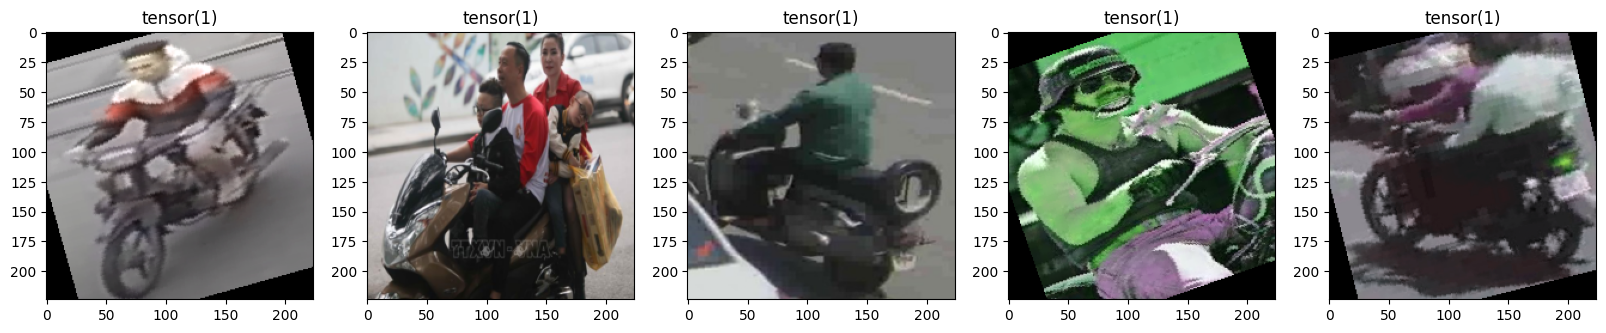

In [21]:
visualize_batch(batch)

In [22]:
len(train_loader)

16

# Models

In [29]:
num_classes = len(dataset.classes)
googlenet_model = models.mobilenet_v2(pretrained=True)
#googlenet_model.fc = nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model.classifier[-1] = nn.Linear(googlenet_model.classifier[-1].in_features, num_classes)
googlenet_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(googlenet_model.parameters(), lr=0.001, momentum=0.9)

In [31]:
num_epochs = 15

training_history = {'loss': [], 'val_loss': []}

for epoch in range(num_epochs):
    googlenet_model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = googlenet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    average_train_loss = running_loss / len(train_loader)

    # Validation
    googlenet_model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = googlenet_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    average_val_loss = val_loss / len(val_loader)

    training_history['loss'].append(average_train_loss)
    training_history['val_loss'].append(average_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Val Loss: {average_val_loss:.4f}')

# Save model
torch.save(googlenet_model.state_dict(), 'mobilenet_finetuned.pth')

Epoch [1/15], Train Loss: 0.6410, Val Loss: 0.5298
Epoch [2/15], Train Loss: 0.5458, Val Loss: 0.4614
Epoch [3/15], Train Loss: 0.4488, Val Loss: 0.3619
Epoch [4/15], Train Loss: 0.3398, Val Loss: 0.3046
Epoch [5/15], Train Loss: 0.2937, Val Loss: 0.2346
Epoch [6/15], Train Loss: 0.2333, Val Loss: 0.1875
Epoch [7/15], Train Loss: 0.2024, Val Loss: 0.1781
Epoch [8/15], Train Loss: 0.1589, Val Loss: 0.2323
Epoch [9/15], Train Loss: 0.1188, Val Loss: 0.1571
Epoch [10/15], Train Loss: 0.1100, Val Loss: 0.1235
Epoch [11/15], Train Loss: 0.1196, Val Loss: 0.3048
Epoch [12/15], Train Loss: 0.1238, Val Loss: 0.1384
Epoch [13/15], Train Loss: 0.1036, Val Loss: 0.3469
Epoch [14/15], Train Loss: 0.0775, Val Loss: 0.1283
Epoch [15/15], Train Loss: 0.0843, Val Loss: 0.1230


### Plotting loss

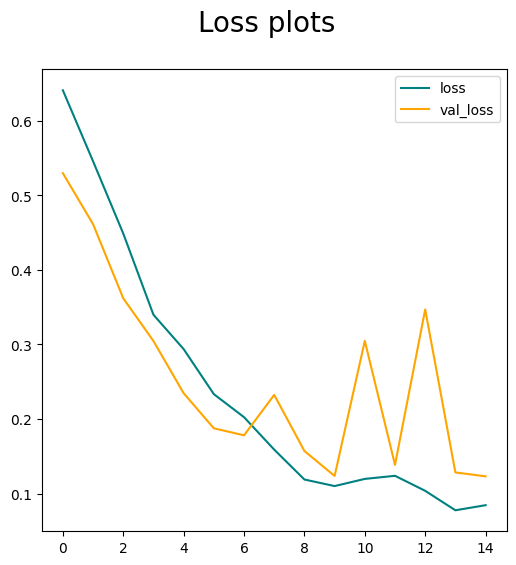

In [32]:
fig = plt.figure(figsize=(6, 6))

plt.plot(training_history['loss'], color='teal', label='loss')
plt.plot(training_history['val_loss'], color='orange', label='val_loss')

fig.suptitle('Loss plots', fontsize=20)
plt.legend(loc="upper right")
plt.show()

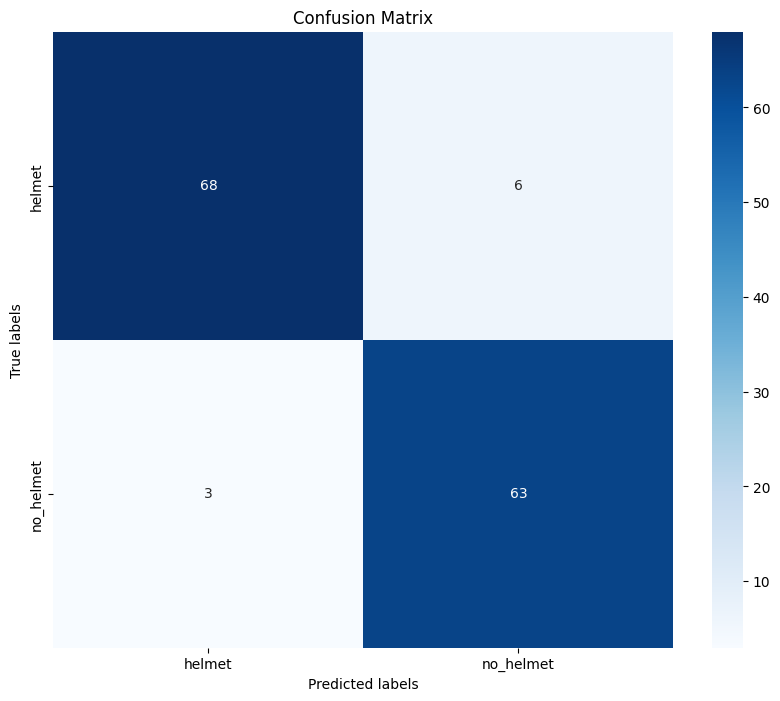

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
googlenet_model.eval()

# Move model to CPU (if it was trained on GPU)
googlenet_model = googlenet_model.to("cpu")

# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Testing loop
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = googlenet_model(inputs)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())

# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
class_names = ['helmet', 'no_helmet']
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [34]:
from sklearn.metrics import f1_score, recall_score, precision_score
print(f"f1: {f1_score(true_labels, predicted_labels)}, precision: {precision_score(true_labels, predicted_labels)}, recall: {recall_score(true_labels, predicted_labels)}")

f1: 0.9333333333333332, precision: 0.9130434782608695, recall: 0.9545454545454546
